# Mathematical Representation of a Perceptron Layer
## (with example in TensorFlow)
---

## Application in TensorFlow

Task: classify handwritten digits

Input: 1797 images of handwritten digits, 8x8 pixels each

Output: 10 classes, [0, 9]

### General

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

### Data Exploration

In [2]:
# load the dataset
from sklearn.datasets import load_digits

digits = load_digits ()
digits.keys ()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

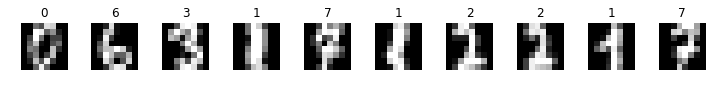

In [3]:
# plot some random images with handwritten images
rnd_idx = np.random.choice (digits['images'].shape[0], 10, replace = False)

fig, axs = plt.subplots (1, len (rnd_idx))

for i in range (len (rnd_idx)):
    axs[i].imshow (digits['images'][rnd_idx[i], :], cmap = 'gray')
    axs[i].set_title (digits['target'][rnd_idx[i]])
    axs[i].axis ('off')

fig.set_size_inches (10, 2)
plt.tight_layout ()
plt.show ()

In [4]:
# insights of the dataset
print ('dataset instances:\n',
       '  m =', digits['images'].shape[0], '\n',
       '  features =', digits['images'].shape[1:], '\n',
       '  feature range = [{}, {}]'.format (digits['images'].min (), digits['images'].max ()), '\n',
       '  feature data type =', digits['images'].dtype)
print ('dataset targets:', '\n',
       '  y =', digits['target_names'], '\n',
       '  targets data type =', digits['target_names'].dtype)

print ('distribution of instances per target:')
cum_percent_of_instances = 0
for i in range (digits['target_names'].shape[0]):
    n_instances_per_label = len (np.where (digits['target'].reshape (-1, 1) == i)[0])
    percent_of_instances = np.round_ (100*n_instances_per_label / digits['images'].shape[0], 2)
    cum_percent_of_instances += percent_of_instances
    print ('  {:2} {:<4} {:>6} % {:>6} %'.format (i, n_instances_per_label, percent_of_instances, np.round_ (cum_percent_of_instances, 2)))

dataset instances:
   m = 1797 
   features = (8, 8) 
   feature range = [0.0, 16.0] 
   feature data type = float64
dataset targets: 
   y = [0 1 2 3 4 5 6 7 8 9] 
   targets data type = int32
distribution of instances per target:
   0 178    9.91 %   9.91 %
   1 182   10.13 %  20.04 %
   2 177    9.85 %  29.89 %
   3 183   10.18 %  40.07 %
   4 181   10.07 %  50.14 %
   5 182   10.13 %  60.27 %
   6 181   10.07 %  70.34 %
   7 179    9.96 %   80.3 %
   8 174    9.68 %  89.98 %
   9 180   10.02 %  100.0 %


### Data Preprocessing

In [5]:
# scale dataset to [0, 1] - min-max scaling
digits_scaled = digits['data'].astype ('f4') / np.max (digits['data'])
np.min (digits_scaled), np.max (digits_scaled)

(0.0, 1.0)

In [6]:
# split dataset into train, validation, test set

# take out 20% of each target class for test
data = []
idx_test = []
for i in range (digits['target_names'].shape[0]):
    i_idx = np.where (digits['target'].reshape (-1, 1) == i)[0]
    rnd_i_idx = np.random.choice (i_idx, int (np.floor (len (i_idx)*0.2)), replace = False)
    digits_Xy = np.concatenate ((digits_scaled[rnd_i_idx], digits['target'][rnd_i_idx].reshape (-1, 1)), axis = 1)
    data.append (digits_Xy)
    idx_test.append (rnd_i_idx)

digits_Xy_test = np.vstack (data)

digits_X_test = digits_Xy_test[:, :64]
digits_y_test = digits_Xy_test[:, 64].astype ('i4')

# delete the test data from dataset
mask = np.ones (digits_scaled.shape[0], dtype = bool)
mask[np.hstack (idx_test)] = False
digits_X = digits_scaled[mask]
digits_y = digits['target'][mask]

# split remaining dataset into train and validation set
from sklearn.model_selection import train_test_split

digits_X_train, digits_X_val, digits_y_train, digits_y_val = train_test_split (digits_X, digits_y, test_size = 0.2, shuffle = True, random_state = 42)


print ('train set:', digits_X_train.shape, digits_y_train.shape, np.round_ (100*digits_X_train.shape[0] / digits_scaled.shape[0], 2), '%')
print ('val set:', digits_X_val.shape, digits_y_val.shape, np.round_ (100*digits_X_val.shape[0] / digits_scaled.shape[0], 2), '%')
print ('test set:', digits_X_test.shape, digits_y_test.shape, np.round_ (100*digits_X_test.shape[0] / digits_scaled.shape[0], 2), '%')

train set: (1153, 64) (1153,) 64.16 %
val set: (289, 64) (289,) 16.08 %
test set: (355, 64) (355,) 19.76 %


### Implementation

In [7]:
# layer
def nn_layer (inputs, units, activation = None):
        
    # X, shape (k, n)
    X = inputs
    
    # W, shape (n, u)
    r = 2 / np.sqrt (units)
    w_init = tf.random_uniform (shape = [int (X.get_shape ()[1]), units], minval = -1.*r, maxval = 1.*r)
    W = tf.Variable (
        initial_value = w_init,
        name = 'weights'
    )
    
    # b, shape (u, 1)
    b = tf.Variable (
        initial_value = tf.zeros (shape = [units]),
        name = 'bias'
    )
    
    # Z = X * W + b with shape (k, u)
    Z = tf.matmul (X, W) + b
    
    # H = activation (Z)
    if activation:
        return activation (Z)
    else:
        return Z

In [8]:
# construction phase
n_inputs = 8*8
n_hidden1 = 256
n_hidden2 = 128
n_outputs = 10


tf.reset_default_graph ()

X = tf.placeholder (
    dtype = tf.float32,
    shape = (None, n_inputs),
    name = 'X'
)
y = tf.placeholder (
    dtype = tf.int32,
    shape = (None),
    name = 'y'
)

fc1 = nn_layer (
    inputs = X,
    units = n_hidden1,
    activation = tf.nn.relu
)
fc2 = nn_layer (
    inputs = fc1,
    units = n_hidden2,
    activation = tf.nn.relu
)
logits = nn_layer (
    inputs = fc2,
    units = n_outputs,
    activation = None
)

with tf.name_scope ('loss'): # cost function
    # sparse_softmax_cross_entropy_with_logits includes softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits (
        labels = y,
        logits = logits
    )
    loss = tf.reduce_mean (xentropy, name = 'loss')

LR = 0.01
with tf.name_scope ('train'):
    optimizer = tf.train.GradientDescentOptimizer (learning_rate = LR)
    training_op = optimizer.minimize (loss)
    
with tf.name_scope ('eval'):
    correct = tf.nn.in_top_k (
        predictions = logits,
        targets = y,
        k = 1
    )
    accuracy = tf.reduce_mean (tf.cast (correct, tf.float32))


init = tf.global_variables_initializer ()
saver = tf.train.Saver ()

In [9]:
# execution phase

N_EPOCHS = 20
BATCH_SIZE = 20
n_batches = int (np.ceil (digits_X_train.shape[0] / BATCH_SIZE))

with tf.Session () as sess:
    init.run ()
    
    for epoch in range (1, N_EPOCHS+1):
        
        for it in range (n_batches):
            
            feed_dict = {
                X : digits_X_train[it*BATCH_SIZE:(it+1)*BATCH_SIZE, :],
                y : digits_y_train[it*BATCH_SIZE:(it+1)*BATCH_SIZE]
            }
            
            sess.run (training_op, feed_dict = feed_dict)
        
        acc_train = accuracy.eval (feed_dict = feed_dict)
        acc_val = accuracy.eval (feed_dict = {X : digits_X_val, y : digits_y_val})
        
        print (epoch, ', train acc:', acc_train, ', val acc:', acc_val)
    
    save_path = saver.save (sess, './digits_final.ckpt')

1 , train acc: 0.9230769 , val acc: 0.816609
2 , train acc: 1.0 , val acc: 0.9134948
3 , train acc: 1.0 , val acc: 0.9446367
4 , train acc: 1.0 , val acc: 0.9550173
5 , train acc: 1.0 , val acc: 0.9584775
6 , train acc: 1.0 , val acc: 0.9584775
7 , train acc: 1.0 , val acc: 0.9584775
8 , train acc: 1.0 , val acc: 0.9688581
9 , train acc: 1.0 , val acc: 0.9688581
10 , train acc: 1.0 , val acc: 0.97231835
11 , train acc: 1.0 , val acc: 0.9688581
12 , train acc: 1.0 , val acc: 0.9688581
13 , train acc: 1.0 , val acc: 0.9688581
14 , train acc: 1.0 , val acc: 0.9688581
15 , train acc: 1.0 , val acc: 0.9653979
16 , train acc: 1.0 , val acc: 0.9653979
17 , train acc: 1.0 , val acc: 0.9653979
18 , train acc: 1.0 , val acc: 0.9653979
19 , train acc: 1.0 , val acc: 0.9653979
20 , train acc: 1.0 , val acc: 0.9653979


### Evaluation

In [10]:
# predictions
with tf.Session () as sess:
    saver.restore (sess, save_path)
    
    Z = logits.eval (feed_dict = {X : digits_X_test})
    y_pred_distr = tf.nn.softmax (Z).eval ()
    y_pred = np.argmax (y_pred_distr, axis = 1)
    acc_test = accuracy.eval (feed_dict = {X : digits_X_test, y : digits_y_test})

INFO:tensorflow:Restoring parameters from ./digits_final.ckpt


In [11]:
acc_test

0.9661972